In [1]:
import tensorflow as tf
import numpy as np

# 8.1 텐서플로 허브에서 사전 훈련된 MobileNet 모델 불러오기
import tensorflow_hub as hub

mobile_net_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2"
model = tf.keras.Sequential([
    hub.KerasLayer(handle=mobile_net_url, input_shape=(224, 224, 3), trainable=False)
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1001)              3540265   
Total params: 3,540,265
Trainable params: 0
Non-trainable params: 3,540,265
_________________________________________________________________


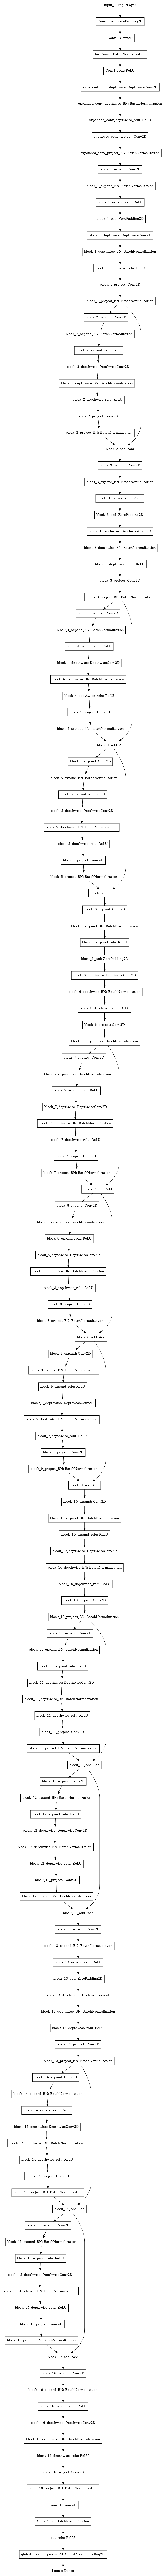

In [2]:
# 그림 8.2 좌측 전체 네트워크 구조 출력 코드
try:
    import pydot_ng as pydot
except ImportError:
    pydot = None
import graphviz

from tensorflow.keras.applications import MobileNetV2

mobilev2 = MobileNetV2()
tf.keras.utils.plot_model(mobilev2)

In [16]:
# 8.2 ImageNetV2-TopImages 불러오기
import os
import pathlib
content_data_url = '/content/sample_data'
data_root_orig = tf.keras.utils.get_file('imagenetV2', 'https://s3-us-west-2.amazonaws.com/imagenetv2public/imagenetv2-topimages.tar.gz', cache_dir=content_data_url, extract=True)
data_root = pathlib.Path(content_data_url + '/datasets/imagenetv2-topimages')
print(data_root)

/content/sample_data/datasets/imagenetv2-topimages
<generator object Path.iterdir at 0x7ff2fd3c6360>


In [17]:
# 8.3 디렉토리 출력
for idx, item in enumerate(data_root.iterdir()):
    print(item)
    if idx == 9:
        break

FileNotFoundError: [Errno 2] No such file or directory: '/content/sample_data/datasets/imagenetv2-topimages'

In [7]:
# 8.4 ImageNet 라벨 텍스트 불러오기
label_file = tf.keras.utils.get_file('label', 'https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
label_text = None
with open(label_file, 'r') as f:
    label_text = f.read().split('\n')[:-1]
print(len(label_text))
print(label_text[:10])
print(label_text[-10:])

16384/10484 [==============================================] - 0s 1us/step
1001
['background', 'tench', 'goldfish', 'great white shark', 'tiger shark', 'hammerhead', 'electric ray', 'stingray', 'cock', 'hen']
['buckeye', 'coral fungus', 'agaric', 'gyromitra', 'stinkhorn', 'earthstar', 'hen-of-the-woods', 'bolete', 'ear', 'toilet tissue']


In [18]:
# 8.5 이미지 확인
import PIL.Image as Image
import matplotlib.pyplot as plt
import random

all_image_paths = list(data_root.glob('*/*'))
all_image_paths = [str(path) for path in all_image_paths]
# 이미지를 랜덤하게 섞습니다.
random.shuffle(all_image_paths)

image_count = len(all_image_paths)
print('image_count:', image_count)

plt.figure(figsize=(12,12))
for c in range(9):
    image_path = random.choice(all_image_paths)
    plt.subplot(3,3,c+1)
    plt.imshow(plt.imread(image_path))
    idx = int(image_path.split('/')[-2]) + 1
    plt.title(str(idx) + ', ' + label_text[idx])
    plt.axis('off')
plt.show()

image_count: 0


IndexError: Cannot choose from an empty sequence